In [187]:
# creating spectrograms from all the files, and saving split labelled versions to disk ready for machine learning
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import cPickle as pickle
import numpy as np
import time
import random 

from scipy.ndimage.interpolation import zoom

#from data_helpers import load_annotations

import nolearn
import nolearn.lasagne
import lasagne.layers

from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
import theano

base = '/media/michael/Seagate/engage/alison_data/golden_set/'
annotation_pkl_dir = base + 'extracted/annotations/'
spec_pkl_dir = base + 'extracted/specs/'
log_dir = base + 'ml_runs/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
HWW = 15
SPEC_HEIGHT = 330

In [189]:
# create a class for the spectrograms, from which we can get minbatches of data
class SpecSampler(object):
    
    def _ensure_correct_shape_spec(self, spec):
        if spec.ndim == 2:
            return spec[None, ...]
        else:
            return spec
    
    def __init__(self, specs, labels, hww):       
        self.specs = np.dstack(self._ensure_correct_shape_spec(spec) for spec in specs)
        self.labels = labels
        self.hww = hww
    
    def _ensure_shape(self, X):
        if X.shape[2] < self.hww * 2:
            return np.pad(X, ((0, 0), (0, 0), (0, self.hww * 2 - X.shape[2])), 'constant')
        else:
            return X
    
    def sample(self, num_per_class, seed=None):
        
        tic = time.time()
        num_samples = num_per_class * len(self.labels)
        channels = self.specs.shape[0]
        height = self.specs.shape[1]
        
        if seed is not None:
            np.random.seed(seed)
        
        X = np.zeros((num_samples, channels, height, self.hww*2), np.float32)
        y = np.zeros(num_samples) * np.nan
        count = 0
        tic = time.time()
        
        for cls in [0, 1]:
            possible_locs = np.where(self.labels==cls)[0]

            if len(possible_locs) >= num_per_class:
                sampled_locs = np.random.choice(possible_locs, num_per_class, replace=False)

                for loc in sampled_locs:
                    X[count] = self._ensure_shape(self.specs[:, :, (loc-self.hww):(loc+self.hww)])
                    y[count] = cls
                    count += 1

        # remove ones we couldn't get
        to_remove = np.isnan(y)
        return X[~to_remove], y[~to_remove]
        
        
#ss = SpecSampler([np.log((0.001+ melspec))[None, :100, :]], {0: bio_zoomed}, 10)

In [194]:
# load data and make list of specsamplers
samplers = []

for fname in os.listdir(spec_pkl_dir):
    
    # load spectrogram and annotations
    spec = pickle.load(open(spec_pkl_dir + fname))[:SPEC_HEIGHT, :]
    annots, wav, sample_rate = pickle.load(
        open(annotation_pkl_dir + fname))
        
    # reshape annotations
    for classname in annots:
        factor = float(spec.shape[1]) / annots[classname].shape[0]
        annots[classname] = zoom(annots[classname], factor)
        
    # create sampler
    logspec = np.log(0.001 + spec)
    logspec_med = logspec - np.median(logspec, axis=1, keepdims=True)
    ss = SpecSampler([logspec_med], annots['biotic'], HWW)
    samplers.append(ss)

In [195]:
class MyBatch(nolearn.lasagne.BatchIterator):
    def __iter__(self):
        bs = self.batch_size
        for sampler in self.X:
            xb, yb = sampler.sample(bs)
            yield xb.astype(np.float32), yb.astype(np.int32)

class MyBatchTest(nolearn.lasagne.BatchIterator):
    def __iter__(self):
        bs = self.batch_size
        for sampler in self.X:
            xb, yb = sampler.sample(bs, seed=10)
            yield xb.astype(np.float32), yb.astype(np.int32)

class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        return samplers[:50], samplers[50:], None, None


In [ ]:
net = {}

net['input'] = InputLayer((None, 1, SPEC_HEIGHT, HWW*2))

net['conv1_1'] = ConvLayer(net['input'], 80, (spec.shape[0] - 10, 6), nonlinearity=vlr)
net['pool1'] = PoolLayer(net['conv1_1'], pool_size=(4, 3), stride=(1, 3))
net['pool1'] = DropoutLayer(net['pool1'], p=0.5)
net['conv1_2'] = ConvLayer(net['pool1'], 80, (1, 3), nonlinearity=vlr)
net['pool2'] = PoolLayer(net['conv1_2'], pool_size=(1, 2), stride=(1, 1))

net['fc6'] = DenseLayer(net['pool2'], num_units=256, nonlinearity=vlr)
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6'], num_units=256, nonlinearity=vlr)
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=2, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

net = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=500,
    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=0.0001,
    update_momentum=0.975,
    verbose=1,
    batch_iterator_train=MyBatch(128),
    batch_iterator_test=MyBatchTest(32),
    train_split=MyTrainSplit(None),
    check_input=False
)

In [ ]:
net.fit(samplers, None)

# Neural Network with 1058722 learnable parameters

## Layer information

  #    name  size
---  ------  --------
  0          1x330x30
  1          80x11x25
  2          80x8x8
  3          80x8x8
  4          80x8x6
  5          80x8x5
  6          256
  7          256
  8          256
  9          256
 10          2
 11          2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.74385       0.68703      1.08272      0.55423  5.06s
      2       0.70442       0.66902      1.05291      0.69853  5.06s
      3       0.69549       0.65945      1.05465      0.71048  5.35s
      4       0.67174       0.65156      1.03098      0.72243  5.17s
      5       0.66395       0.64614      1.02757      0.70956  4.87s
      6       0.65019       0.63669      1.02121      0.71691  5.31s
      7       0.63978       0.63120      1.01359      0.70864  5.37s
      8       0.63222       0.62592      1.0

<module 'matplotlib.pyplot' from '/home/michael/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

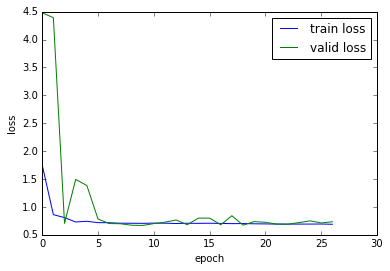

In [169]:
def plot_loss(net):
    train_loss = [row['train_loss'] for row in net.train_history_]
    valid_loss = [row['valid_loss'] for row in net.train_history_]
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    return plt
plot_loss(net)